In [1]:
# split into train and test set
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
import numpy as np

from mrcnn import visualize

Using TensorFlow backend.


In [2]:
# class that defines and loads the kangaroo dataset
class Dataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, "picture_frame")
        # define data locations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        # find all images
        i=0
        for filename in listdir(images_dir):
            i+=1
            # extract image id
            image_id = filename[:-4]
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
            if i==1:
                print(image_id)

    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('picture_frame'))
        return masks, asarray(class_ids, dtype='int32')

    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']


In [3]:
# define a configuration for the model
class FrameConfig(Config):
    # Give the configuration a recognizable name
    NAME = "pictureframe_cfg"
    # Number of classes (background + picture frame)
    NUM_CLASSES = 1 + 1
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 131
    # Skip detections with < 90% confidence     
    DETECTION_MIN_CONFIDENCE = 0.9

In [4]:
# train set
train_set = Dataset()
train_set.load_dataset('data/train', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = Dataset()
test_set.load_dataset('data/val', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

# prepare config
config = FrameConfig()
config.display()

795c0fb05fa9fa0a_jpg.rf.cf2b1d95d0176c2a173f08ac28011aef
Train: 1679
00e77aab3b46d53f_jpg.rf.4574093cacac754f6a97d689e71b11c9
Test: 51

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_los

In [5]:
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [6]:
# load weights (mscoco)


model.load_weights('mask_rcnn_pictureframe_cfg_0001.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])


2022-05-14 20:29:54.951686: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-14 20:29:54.970890: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe3ba171950 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-14 20:29:54.970905: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


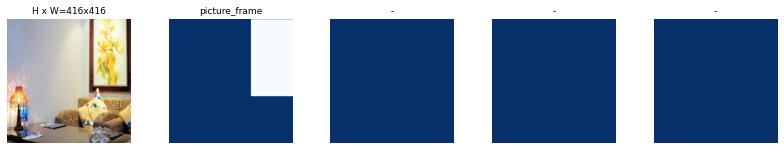

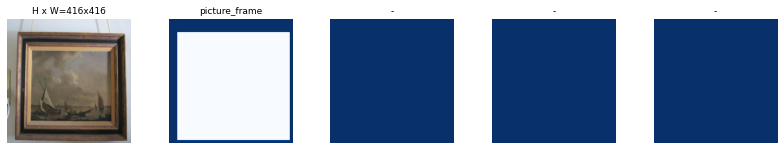

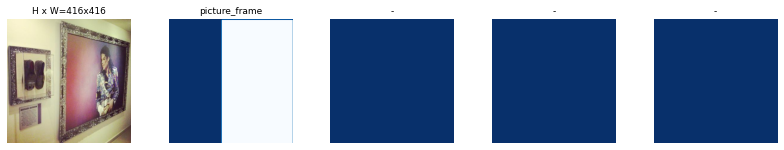

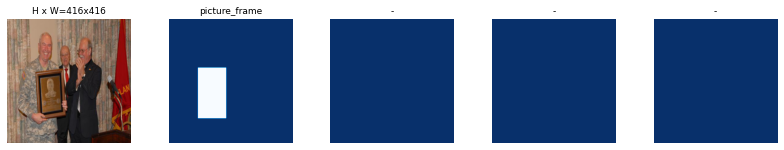

In [7]:
# Load and display random samples
image_ids = np.random.choice(test_set.image_ids, 4)
for image_id in image_ids:
    image = test_set.load_image(image_id)
    mask, class_ids = test_set.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, test_set.class_names)

In [8]:
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=1, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./pictureframe_cfg20220514T2029/mask_rcnn_pictureframe_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4 

/Users/stefgielen/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/stefgielen/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/stefgielen/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/Users/stefgielen/.local/lib/python3.7/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/1
131/131 [==============================] - 4753s 36s/step - loss: 0.7275 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.2591 - mrcnn_class_loss: 0.0604 - mrcnn_bbox_loss: 0.1870 - mrcnn_mask_loss: 0.2166 - val_loss: 0.6671 - val_rpn_class_loss: 0.0057 - val_rpn_bbox_loss: 0.2231 - val_mrcnn_class_loss: 0.0647 - val_mrcnn_bbox_loss: 0.1956 - val_mrcnn_mask_loss: 0.1780

